## Simple Workflow

In [1]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END

In [2]:
from typing import TypedDict

# define state
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [3]:
def calculate_bmi(state: BMIState) -> BMIState:
    """calculates state"""

    weight = state["weight_kg"]
    height = state["height_m"]

    bmi = weight / (height**2)
    state["bmi"] = round(bmi, 2)

    return state

In [4]:
def bmi_category(state: BMIState) -> BMIState:
    """labels bmi category"""

    if state["bmi"] > 10:
        state["category"] = "Unhealthy"

    elif state["bmi"] < 5:
        state["category"] = "Unhealty"

    else:
        state["category"] = "healthy"

    return state

In [5]:
# define graph
graph = StateGraph(BMIState)

# add node
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node("bmi_category", bmi_category)

# add edges
graph.add_edge(START, 'calculate_bmi')
graph.add_edge("calculate_bmi", "bmi_category")
graph.add_edge("bmi_category", END)

# compile graph
workflow = graph.compile()

In [6]:
# execute graph
input_state: BMIState = {"weight_kg": 80, "height_m": 1.6}  # type: ignore
output_state = workflow.invoke(input_state)
print(output_state)

{'weight_kg': 80, 'height_m': 1.6, 'bmi': 31.25, 'category': 'Unhealthy'}


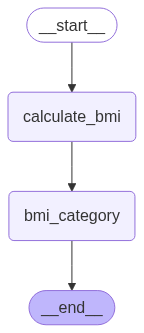

In [7]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

## Simple LLM workflow

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict

In [10]:
model = ChatOllama(model= 'mistral')
model.invoke("How are you?")

AIMessage(content=" I'm just a computer program, so I don't have feelings or emotions. But I'm working perfectly fine and ready to help you with any questions or tasks you might have! What can I assist you with today?", additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-08-03T11:32:23.7942572Z', 'done': True, 'done_reason': 'stop', 'total_duration': 27256041400, 'load_duration': 24555904900, 'prompt_eval_count': 9, 'prompt_eval_duration': 415259200, 'eval_count': 48, 'eval_duration': 2284216900, 'model_name': 'mistral'}, id='run--5915fab3-e958-43c8-8995-7415756f8cdd-0', usage_metadata={'input_tokens': 9, 'output_tokens': 48, 'total_tokens': 57})

In [11]:
class LLMState(TypedDict):
    question: str
    answer: str

In [12]:
def llm_qa(state: LLMState)-> LLMState:
    question = state["question"]

    prompt = f"Answer the following {question}"

    answer = str(model.invoke(prompt).content)

    state['answer'] = answer

    return state

In [13]:
graph = StateGraph(LLMState)

graph.add_node('llm_qa', llm_qa)

graph.add_edge(START, 'llm_qa')
graph.add_edge('llm_qa', END)


workflow = graph.compile()

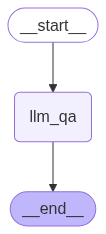

In [14]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [15]:
# execute
initial_state: LLMState = {'question': 'How far is moon from earth?', 'answer': ''}

output_state = workflow.invoke(initial_state)

In [16]:
output_state['answer']

' The average distance from the Moon to Earth is approximately 238,900 miles (384,400 kilometers). However, this distance varies because both the Earth and the Moon orbit around the Sun. At its closest point, known as perigee, the Moon can be as close as about 225,623 miles (363,104 kilometers) from Earth, while at its farthest point, or apogee, it can be about 252,088 miles (405,696 kilometers) away.'

## Prompt Chaining

In [26]:
from langgraph.graph import StateGraph, START, END

In [27]:
from typing import TypedDict

# create a state schema
class BlogState(TypedDict):
    title: str
    outline: str
    content: str

In [28]:
from langchain_ollama import ChatOllama

# initiate a model
llm = ChatOllama(model="gemma3:4b")

AIMessage(content="Okay, let's break down what a mobile number is:\n\n**What is a Mobile Number?**\n\nA mobile number is a unique identification number assigned to a mobile phone (like a smartphone or a basic cell phone). It's essentially a way for your phone to connect to a mobile network and communicate with other devices and people.\n\n**Here's a more detailed explanation:**\n\n* **It's a Unique Identifier:** Just like a house address, every mobile number is distinct.  No two phones can have the same number.\n* **How it Works:** When you make a call, send a text message, or use data, your phone transmits the signal to a cell tower operated by a mobile network operator (like Verizon, AT&T, T-Mobile, Vodafone, etc.). This network then routes the communication to its destination.\n* **Structure of a Mobile Number (Varies by Country):** The exact format of a mobile number differs depending on the country. However, a common structure looks like this:\n    * **Country Code:**  This is the

In [34]:
from langchain_ollama import ChatOllama

# initiate a model
model = ChatOllama(model="granite3.3:2b")
model.invoke("What is mobile number?")

AIMessage(content='A mobile number, also known as a cell phone number or a telephone number, is a sequence of numbers assigned to either end-user subscription cards or embedded memory chips in mobile devices, although the latter is less common. It is used to distinguish one mobile subscriber from another.', additional_kwargs={}, response_metadata={'model': 'granite3.3:2b', 'created_at': '2025-08-03T13:29:27.1079553Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1644649600, 'load_duration': 19104300, 'prompt_eval_count': 48, 'prompt_eval_duration': 99992500, 'eval_count': 58, 'eval_duration': 1521374200, 'model_name': 'granite3.3:2b'}, id='run--3000b965-8d5f-4f24-b6b5-6f2fb88d254f-0', usage_metadata={'input_tokens': 48, 'output_tokens': 58, 'total_tokens': 106})

In [35]:
def create_outline(state: BlogState) -> BlogState:

    title = state['title']
    prompt = f"Generate a detailed outline for a blog on the topic = {title}"
    outline = model.invoke(prompt).content
    state['outline'] = str(outline)
    return state


In [36]:
def create_blog(state: BlogState) -> BlogState:
    title = state['title']
    outline = state['outline']
    prompt = f"Write a detailed blog on the title = {title} using the following outline: \n {outline}"
    content = model.invoke(prompt).content
    state['content'] = str(content)
    return state

In [37]:
graph = StateGraph(BlogState)

# nodes
graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)

# edges
graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline','create_blog')
graph.add_edge('create_blog', END)


# compile
workflow = graph.compile()

In [38]:
initial_state: BlogState = {'title': 'Rise of AI in India', 'outline': '', 'content': ''}
final_state = workflow.invoke(initial_state)
print(final_state)

{'title': 'Rise of AI in India', 'outline': "Title: The Rise of Artificial Intelligence in India: Opportunities, Challenges, and Future Prospects\n\nI. Introduction\n   A. Brief overview of the AI landscape globally\n   B. Focus on the unique AI journey in India\n   C. Importance of understanding AI's impact on the Indian economy and society\n\nII. Historical Background of AI in India\n   A. Early beginnings and research (1960s-1980s)\n      1. Establishment of AI institutions like IITs, IISc\n      2. Key milestones and notable figures\n   B. The decline and resurgence (1990s-2010s)\n      1. Factors contributing to the slowdown\n      2. Revival and focus on industry applications\n\nIII. Current State of AI in India\n\n   A. Government initiatives and policies\n      1. NITI Aayog's National Strategy for Artificial Intelligence (NSAI)\n      2. Atmanirbhar Bharat Abhiyan and its implications for AI development\n   B. Private sector investments and startups\n      1. Prominent AI comp

In [39]:
final_state['outline']

"Title: The Rise of Artificial Intelligence in India: Opportunities, Challenges, and Future Prospects\n\nI. Introduction\n   A. Brief overview of the AI landscape globally\n   B. Focus on the unique AI journey in India\n   C. Importance of understanding AI's impact on the Indian economy and society\n\nII. Historical Background of AI in India\n   A. Early beginnings and research (1960s-1980s)\n      1. Establishment of AI institutions like IITs, IISc\n      2. Key milestones and notable figures\n   B. The decline and resurgence (1990s-2010s)\n      1. Factors contributing to the slowdown\n      2. Revival and focus on industry applications\n\nIII. Current State of AI in India\n\n   A. Government initiatives and policies\n      1. NITI Aayog's National Strategy for Artificial Intelligence (NSAI)\n      2. Atmanirbhar Bharat Abhiyan and its implications for AI development\n   B. Private sector investments and startups\n      1. Prominent AI companies in India (e.g., Flipkart, Ola, Paytm)\

In [40]:
final_state["content"]

'Title: The Rise of Artificial Intelligence in India: Opportunities, Challenges, and Future Prospects\n\n**I. Introduction**\n\nArtificial Intelligence (AI) has permeated global industries, revolutionizing sectors from healthcare to finance, retail to transportation. However, as we delve into the Indian context, we find a unique journey, one that is not only intertwined with economic development but also cultural and societal transformation. Understanding AI\'s impact on India\'s economy and society is of paramount importance, especially given its potential to reshape industries, improve public services, and address pressing challenges.\n\n**II. Historical Background of AI in India**\n\nA. Early beginnings and research (1960s-1980s): The 1960s marked the initial forays into AI research in India, with institutions like Indian Institute of Technology (IIT) Bombay and Indian Institute of Science (IISc) Kharuwakpur establishing foundational programs. Key milestones included the creation of